In [ ]:
def compound_interest(principle: float, rate: float, peroids: int): 
    # Calculates compound interest  
    total_return = principle * (pow((1 + rate / 100), peroids)) 
    print("Total Interest $:", round(total_return, 2))
    print("Anualized Peroid %", round(total_return / principle, 1) * 100)

In [ ]:
import ray
ray.shutdown()

In [55]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pandas_bokeh
from qgrid import show_grid
# import finplot as fplt

import polygon_rest_api as papi
import polygon_ws_api as pws
import polygon_backfill as pb
import polygon_s3 as ps3

import bar_samples as bs
import bar_labels as bl
import bar_meta as bm
import filters as ft

import flow_backfill as fb

# import market_cluster as mc

import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

# import ipdb
# ipdb.set_trace(context=10)

# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG' are other good diverging colormaps
# pd.set_option('precision', 2)

# .plot_bokeh(sizing_mode="scale_height")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
symbol='GLD'
# symbol = 'market'
# date = '2020-01-02'
# start_date = '2020-01-01'
start_date = '2020-10-01'
end_date = '2020-10-10'
# symbols=['SPY', 'QQQ']
tick_type='trades'

thresh = {
    # GT thresholds
    'renko_reveral_multiple': 2,
    'duration_sec': 60*60,
    # LT thresholds
    'min_duration_sec': 15,
    'min_tick_count': 30,
}

horizon_mins=30

In [248]:
s = 56000

In [299]:
plist = df.price[0:100].to_list()

/Users/bobcolner/opt/miniconda3/envs/quant2/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:>

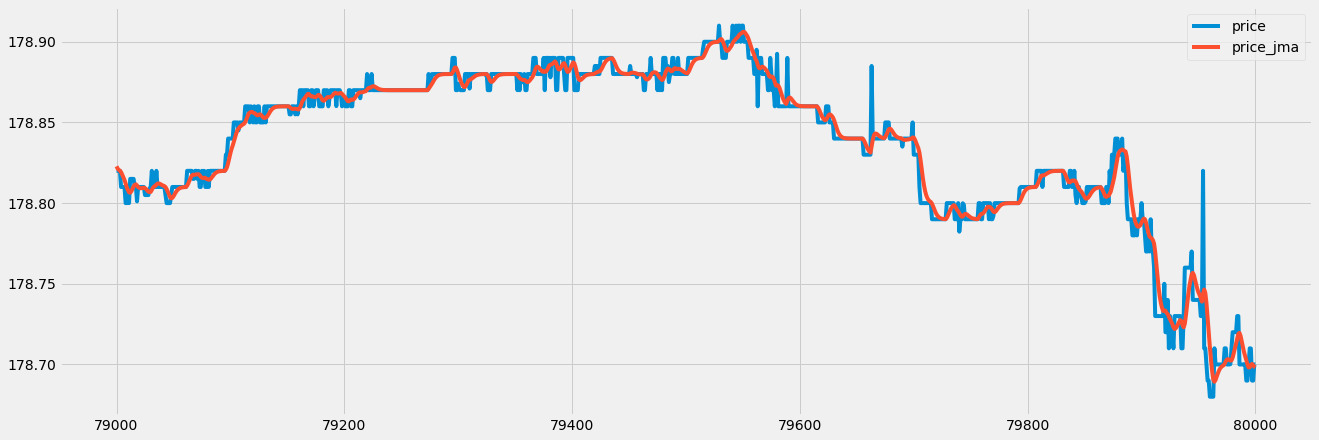

In [365]:
s += 1000
# s -= 1000
sdf = df.loc[df.irregular==False]
# sdf = df
ft.jma_filter_df(sdf, 'price', length=5, power=1, phase=-100).loc[s:s+1000, ['price', 'price_jma']].plot()

In [368]:
sdf2 = ft.jma_filter_df(sdf, 'price', length=5, power=.5)

/Users/bobcolner/opt/miniconda3/envs/quant2/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [391]:
sdf2.price.plot_bokeh(sizing_mode='scale_height')

Figure(id='1004', ...)

In [387]:
(abs(sdf2.price - sdf2.price_jma) / sdf2.price_jma).describe(percentiles=[.99,.999,.9999])

count     80267.000000
mean          0.000051
std           0.001202
min           0.000000
50%           0.000021
99%           0.000265
99.9%         0.001259
99.99%        0.057283
max           0.141686
dtype: float64

In [382]:
abs(sdf2.price - sdf2.price_jma).describe(percentiles=[.99,.999,.9999])

count     80267.000000
mean          0.008920
std           0.191775
min           0.000000
50%           0.003826
99%           0.047221
99.9%         0.225528
99.99%        9.622747
max          22.052979
dtype: float64

In [ ]:
abs(sdf2.price - sdf2.price_jma).describe

/Users/bobcolner/opt/miniconda3/envs/quant2/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:>

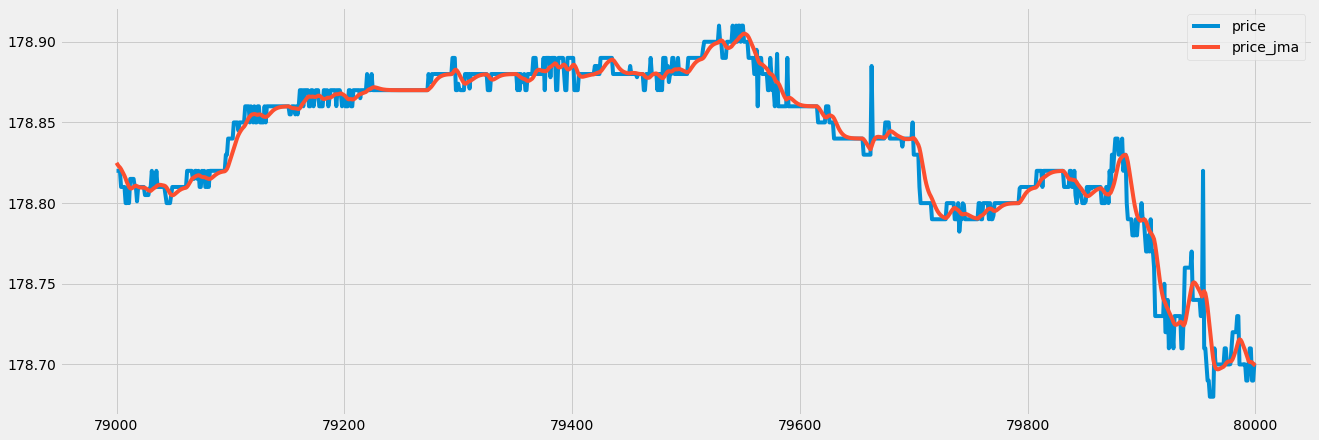

In [366]:
ft.jma_filter_df(sdf, 'price', length=5, power=.5).loc[s:s+1000, ['price', 'price_jma']].plot()

In [ ]:
fb.run_backfill(symbols=['GLD'], tick_type='trades', start_date='2020-10-01')
# fb.run_backfill(symbols=['market'], tick_type='daily', start_date='2020-10-01')

In [ ]:
import ray
ray.init(ignore_reinit_error=True, num_cpus=4, dashboard_port=8080)

daily_bar_stats_df, labeled_bar_dates, stacked_bars_df = bm.bars_workflow_ray( 
    symbol, 
    start_date, 
    end_date, 
    thresh,
    imbalance_thresh=0.9
)

In [ ]:
import pickle 
fio = open('bars_workflow_ray-new.pickle', 'wb') 
pickle.dump((daily_bar_stats_df, labeled_bar_dates, stacked_bars_df), fio)

In [ ]:
data = (daily_bar_stats_df, labeled_bar_dates, stacked_bars_df)
file = open('test.pickle', mode='wb')
pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open("test.pickle", "rb") as input_file:
    e = pickle.load(input_file)

In [ ]:
lbars_df[['price_wmean', 'label_rrr']].plot_bokeh(sizing_mode="scale_height")
# 17, 31

In [ ]:
lbars_df[['price_wmean', 'label_rrr']].plot(subplots=True, figsize=[17,12])

In [21]:
df = ps3.load_ticks(symbol, date='2020-11-04')

GLD 2020-11-04 trying to get ticks from local file...
